In [1]:
import pandas as pd
import numpy as np
import os
import math
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [1183]:
file_path='./data/10000.xls'
#file_path1='./data/1万土壤数据.xlsx'
data1=pd.read_excel(file_path,sheet_name='中河2')
# data2=pd.read_excel(file_path,sheet_name='孤山岭1')
# data3=pd.read_excel(file_path,sheet_name='石板沟1')
# data4=pd.read_excel(file_path,sheet_name='摩云岭1')
data1.head()

,X,Y,Au,Ag,As,Sb,Bi,Co,Cu,Mo,Ni,Pb,W,Zn
0,382898.8,52224.9,1.10,0.06,27.0,6.31,0.31,13.3,20.6,0.99,22.6,19.9,1.95,58.1
1,382894.8,52224.9,1.85,0.04,28.1,6.52,0.40,14.2,20.3,1.39,25.3,23.3,2.46,69.9
2,382890.8,52224.9,1.82,0.08,25.9,4.16,0.37,15.5,22.1,1.09,29.6,37.1,3.28,63.3
3,382886.8,52224.9,2.26,0.06,26.7,6.24,0.31,15.3,24.3,2.28,31.3,68.4,4.75,73.2
4,382882.8,52224.9,1.22,0.08,26.3,5.22,0.31,14.2,23.0,1.21,29.3,33.4,5.18,76.4


In [1184]:
def dist(location_test):
    dist=[]
    loc_list=location_test.values
    for i in range(len(location_test)):
        tmp=[]
        for j in range(len(location_test)):
            tmp.append(np.linalg.norm(loc_list[i]-loc_list[j]))
        dist.append(tmp)
    return dist

In [1185]:
location_test=data1.loc[:,['X','Y']]
dists=dist(location_test)


In [1187]:
dists[0][0]

0.0

In [1315]:
data_test1=data1.loc[:,['Au','Ag']]
print(data_test1[0:1])
print(location_test.shape)


    Au    Ag
0  1.1  0.06
(3925, 2)


In [1316]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler() #min-max标准化
#scaler = preprocessing.StandardScaler()  #z-score标准化
# data_trian = scaler.fit_transform(data_trian)
# data_test = scaler.fit_transform(data_test)
# data_trian1=scaler.fit_transform(data_trian1) 
data_test1=scaler.fit_transform(data_test1) 
# data_trian2=scaler.fit_transform(data_trian2) 
# data_test2=scaler.fit_transform(data_test2) 

In [1317]:
#滑动窗口长度；步长
sequence_length = 16#采样点数量
time_step =4#滑窗步长

In [1318]:
def get_data1(start, end, data,location, sequence_length, time_step,dist):
    import heapq
    result=[]
    newloc=[]
    loc1=location.values
    for i in range(start,end,time_step):
        tmp=dist[i]
        idx=map(tmp.index,heapq.nsmallest(sequence_length,tmp))
        idx=sorted(idx)
        res=[]
        newl=[]
        for j in idx:
            res.append(data[j])
            newl.append(loc1[j])
        result.append(res)
        newloc.append(newl)
    result=np.array(result)
    newloc=np.array(newloc)
    return result,newloc
            

In [1319]:
X_test,loc_test = get_data1(0, len(data_test1), data_test1,location_test, sequence_length, time_step,dists)
print(X_test.shape)
print(data_test1.shape)

(982, 16, 2)
(3925, 2)


In [1320]:
import tensorflow as tf 
from keras.models import Model,Input,load_model, Sequential 
from keras.layers import Conv1D, Dropout, Dense  
from keras.layers import MaxPooling1D, UpSampling1D, Flatten, Reshape 
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [1321]:
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, RepeatVector
from keras.layers.noise import GaussianDropout,GaussianNoise


In [1322]:
sample_length=X_test.shape[1]
feature_dim=X_test.shape[2]
print(sample_length,feature_dim)

16 2


In [1323]:
data=Input(shape=(sample_length,feature_dim ))
x=GaussianNoise(0.01)(data)
x=Conv1D(filters=16, kernel_size=5, padding='same', activation='relu',input_shape=(sample_length, feature_dim))(x)
x=MaxPooling1D(pool_size=2)(x)       
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//2,8))(x)
encoded=MaxPooling1D(pool_size=2)(x)

x=UpSampling1D(size=2)(encoded)
x=Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',input_shape=(sample_length//2,8))(x)
x=UpSampling1D(size=2)(x)
x=Conv1D(filters=16, kernel_size=5, padding='same', activation='relu',input_shape=(sample_length,8))(x)
decoded=Conv1D(filters= feature_dim, kernel_size=5, padding='same', activation='sigmoid',input_shape=(sample_length,16))(x)
       
autoencoder = Model(data, decoded)
autoencoder.compile(loss="mse", optimizer='adam')
encoder_model = Model(data,encoded)

In [1324]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
autoencoder.fit(X_test, X_test,epochs=100,batch_size=128,shuffle=True,validation_split=0.1,callbacks=[early_stopping])

Train on 883 samples, validate on 99 samples
Epoch 1/100
883/883 [==============================] - 4s 5ms/step - loss: 0.2434 - val_loss: 0.2394
Epoch 2/100
883/883 [==============================] - 0s 66us/step - loss: 0.2346 - val_loss: 0.2279
Epoch 3/100
883/883 [==============================] - 0s 63us/step - loss: 0.2199 - val_loss: 0.2089
Epoch 4/100
883/883 [==============================] - 0s 63us/step - loss: 0.1958 - val_loss: 0.1781
Epoch 5/100
883/883 [==============================] - 0s 62us/step - loss: 0.1579 - val_loss: 0.1326
Epoch 6/100
883/883 [==============================] - 0s 62us/step - loss: 0.1066 - val_loss: 0.0782
Epoch 7/100
883/883 [==============================] - 0s 62us/step - loss: 0.0547 - val_loss: 0.0348
Epoch 8/100
883/883 [==============================] - 0s 62us/step - loss: 0.0214 - val_loss: 0.0140
Epoch 9/100
883/883 [==============================] - 0s 63us/step - loss: 0.0081 - val_loss: 0.0070
Epoch 10/100
883/883 [================

883/883 [==============================] - 0s 68us/step - loss: 4.1130e-04 - val_loss: 0.0023
Epoch 78/100
883/883 [==============================] - 0s 57us/step - loss: 4.1121e-04 - val_loss: 0.0023
Epoch 79/100
883/883 [==============================] - 0s 57us/step - loss: 4.1115e-04 - val_loss: 0.0023
Epoch 80/100
883/883 [==============================] - 0s 69us/step - loss: 4.1108e-04 - val_loss: 0.0023
Epoch 81/100
883/883 [==============================] - 0s 63us/step - loss: 4.1101e-04 - val_loss: 0.0023
Epoch 82/100
883/883 [==============================] - 0s 63us/step - loss: 4.1098e-04 - val_loss: 0.0023
Epoch 83/100
883/883 [==============================] - 0s 63us/step - loss: 4.1094e-04 - val_loss: 0.0023
Epoch 84/100
883/883 [==============================] - 0s 54us/step - loss: 4.1094e-04 - val_loss: 0.0023
Epoch 85/100
883/883 [==============================] - 0s 74us/step - loss: 4.1085e-04 - val_loss: 0.0023
Epoch 86/100
883/883 [============================

In [1325]:
encoded_data =encoder_model.predict(X_test)
print(X_test.shape)
print(encoded_data.shape)
# print(encoded_data[0])

(982, 16, 2)
(982, 4, 8)


In [1326]:
encoded_data1=np.sum(encoded_data,axis=2)
# encoded_data1=encoded_data.reshape([498,32])
print(encoded_data1[0])
print(encoded_data1.shape)

[1.3574797 1.3590193 1.3568652 1.3571761]
(982, 4)


In [1327]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score

In [1328]:
# #rbf构造邻接矩阵
# X=encoded_data1
# scores=[]
# s=dict()
# label={}
# for index,gamma in enumerate([0.01,0.1,1,10]):
#     for index,k in enumerate((4,5,6,7,8,9)):
#         pred_y=SpectralClustering(n_clusters=k, gamma=gamma).fit_predict(X)
#         print("Calinski-Harabasz Score with gamma=",gamma,"n_cluster=",k,"score=",calinski_harabaz_score(X,pred_y))
#         tmp=dict()
#         tmp['gamma']=gamma
#         tmp['n_cluster']=k
#         tmp['score']=calinski_harabaz_score(X,pred_y)
#         s[calinski_harabaz_score(X,pred_y)]=tmp
#         label[(gamma,k)]=pred_y
#         scores.append(calinski_harabaz_score(X,pred_y))
# gamma,n_cluster=s.get(np.max(scores))['gamma'],s.get(np.max(scores))['n_cluster']
# last_label=label[(gamma,n_cluster)]
# print(np.max(scores))
# print("最大得分项：")
# print(s.get(np.max(scores)))

In [1329]:
#KNN法构造邻接矩阵
X=encoded_data1
scores=[]
s=dict()
label={}
for index,nb in enumerate([9,10,11,12,13,14,15,16]):
    for index,k in enumerate((4,5,6,7,8,9,10,11,12,13,14)):
        pred_y=SpectralClustering(affinity='nearest_neighbors',n_clusters=k, n_neighbors=nb).fit_predict(X)
        print("Calinski-Harabasz Score with n_neighbors=",nb,"n_cluster=",k,"score=",calinski_harabasz_score(X,pred_y))
        tmp=dict()
        tmp['n_neighbors']=nb
        tmp['n_cluster']=k
        tmp['score']=calinski_harabasz_score(X,pred_y)
        s[calinski_harabasz_score(X,pred_y)]=tmp
        label[(nb,k)]=pred_y
        scores.append(calinski_harabasz_score(X,pred_y))
nb,n_cluster=s.get(np.max(scores))['n_neighbors'],s.get(np.max(scores))['n_cluster']
last_label=label[(nb,n_cluster)]
print(np.max(scores))
print("最大得分项：")
print(s.get(np.max(scores)))

Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 4 score= 172.73122887636407
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 5 score= 130.00366387186153
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 6 score= 105.61879814980716
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 7 score= 97.34196018460766
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 8 score= 85.70877146320605
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 9 score= 69.91048255387248
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 10 score= 89.58396814824708
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 11 score= 86.4635574505613
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 12 score= 81.45882860988515
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 13 score= 73.97658302853588
Calinski-Harabasz Score with n_neighbors= 9 n_cluster= 14 score= 68.68733213396249
Calinski-Harabasz Score with n_neighbors= 10 n_cluster= 4 score= 171.17200515279976
Calinsk

In [1278]:
def savelabel(loc,label):
    n=len(set(label))
    dic0={}
    for i in label:
        if i in dic0:
            dic0[i]+=1
        else:
            dic0[i]=1
    sorted_x = sorted(dic0.items(), key=lambda x : x[1], reverse=True)
    newlabel=[-1]*len(label)
    for i in range(n):
        k,v=sorted_x[i]
        for j in range(len(label)):
            if label[j]==k:
                newlabel[j]=i           
    data=[]
    dic={}
    for i in range(loc.shape[0]):
        loc1=loc[i]
        lab=newlabel[i]
        for j in range(loc1.shape[0]):
            x,y=loc1[j]
            if (y,x) in dic:
                dic[(y,x)].append(lab)
            else:
                dic[(y,x)]=[lab]
    for tup in dic:
        y,x=tup
        count=0
        dic1={}
        lis=dic[tup]
        for lab in lis:
            if lab in dic1:
                dic1[lab]+=1
            else:
                dic1[lab]=1
        mx=max(dic1.values())
        for k,v in dic1.items():
            if v==mx:
                mostlab=k
                break
        data.append([y,x,mostlab])
    
    return data
        

In [1330]:
data=savelabel(loc_test,last_label)
data=pd.DataFrame(data)
print(data.shape)
data.columns=['Y','X','label']
with pd.ExcelWriter('out/CAE_Cluster/jianlishuiku/AuAg_4.xlsx') as writer:
    data.to_excel(writer,sheet_name='AuAg')

(3912, 3)


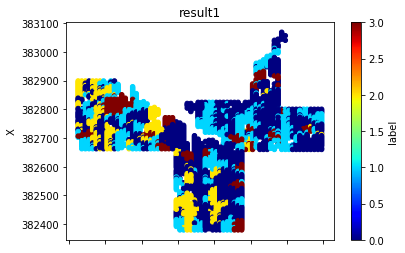

In [1331]:
import matplotlib.pyplot as plt
data.plot.scatter('Y', 'X', c='label', colormap='jet')
plt.title('result1')
plt.show()